# Wikipedia Album Detail Extract

In [32]:
import os
import re
from urllib.parse import urljoin
import datetime as dt

import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
import numpy as np
import scipy
import scipy.sparse

import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

from IPython.display import display, HTML, clear_output

In [2]:
%run ./url_cache.ipynb
%run ./wikipedia_access.ipynb
%run ./wikipedia_album_detail_lib.ipynb

## Configure DB and Load Album Extract

In [3]:
db = sqlite3.Connection("var/data/music.db")

In [4]:
url_cache = URLContentCacheSqlite(db)

wayl_db = WikipediaAlbumYearListsDB(db)
albums = wayl_db.get_all()

### Get Albums With Detail Links

In [5]:
def get_album_link(links):
    if links is not None and 'Album' in links and len(links['Album']) > 0:
        return links['Album'][0]['href']
    
albums['AlbumLink'] = albums.Links.apply(get_album_link)

In [6]:
albums_w_detail_links = albums[albums.AlbumLink.notnull()]

### Download Links

In [7]:
# See what was downloaded already
downloaded_urls = pd.read_sql(f"""
    select url
    from url_cache
""", db)

downloaded_urls = set(downloaded_urls.url)
print(f"Already downloaded {len(downloaded_urls)} album details.")

d_count = len(downloaded_urls)

for _, album_row in albums_w_detail_links[~albums_w_detail_links.AlbumLink.isin(downloaded_urls)].iterrows():
    print(f"[{d_count + 1}] Getting: {album_row.Artist} - {album_row.Album} [{album_row.Year}]")
    r = url_cache.get(album_row.AlbumLink)
    if r is None:
        print(f"[WARNING] link not found.")
    d_count += 1
    
    if (d_count % 25) == 0:
        clear_output()

Already downloaded 29504 album details.
[29505] Getting: The Aislers Set - The Last Match (album) [2000]
[WARNING] link not found.
[29506] Getting: The Business/Dropkick Murphys - Mob Mentality [2000]
[WARNING] link not found.
[29507] Getting: Happyland - Welcome To... Happyland [1998]
[WARNING] link not found.
[29508] Getting: Zumpano - Look What The Rookie Did [1995]
[WARNING] link not found.
[29509] Getting: Björk - The Best Mixes from the Album Debut for All the People Who Don't Buy white Labels [1994]
[WARNING] link not found.
[29510] Getting: Prince - The black Album [1994]
[WARNING] link not found.
[29511] Getting: Atkins - Atkins [1982]
[WARNING] link not found.
[29512] Getting: Robocar Poli - Scott Polin [1973]
[WARNING] link not found.
[29513] Getting: Ptolomy Pscycon - Loose Capacitor [1971]
[WARNING] link not found.
[29514] Getting: Booker T & Priscilla Coolidge - Booker T. & Priscilla [1971]
[WARNING] link not found.


## Build Document Word Lists

In [8]:
ad_word_retriever = AlbumDetailWPDocWordsRetriever(url_cache, db)

In [9]:
ad_word_retriever.process_albums(albums)

[2021-10-25 20:45:50.388985] Processed 1000 albums.
[2021-10-25 20:45:50.660925] Processed 2000 albums.
[2021-10-25 20:45:51.051302] Processed 3000 albums.
[2021-10-25 20:45:51.410301] Processed 4000 albums.
[2021-10-25 20:45:51.763217] Processed 5000 albums.
[2021-10-25 20:45:52.146807] Processed 6000 albums.
[2021-10-25 20:45:52.502923] Processed 7000 albums.
[2021-10-25 20:45:52.921686] Processed 8000 albums.
[2021-10-25 20:45:53.346506] Processed 9000 albums.
[2021-10-25 20:45:53.735605] Processed 10000 albums.
[2021-10-25 20:45:54.130438] Processed 11000 albums.
[2021-10-25 20:45:54.517922] Processed 12000 albums.
[2021-10-25 20:45:54.864763] Processed 13000 albums.
[2021-10-25 20:45:55.234388] Processed 14000 albums.
[2021-10-25 20:45:55.637402] Processed 15000 albums.
[2021-10-25 20:45:55.966393] Processed 16000 albums.
[2021-10-25 20:45:56.330506] Processed 17000 albums.
[2021-10-25 20:45:56.684489] Processed 18000 albums.
[2021-10-25 20:45:57.084286] Processed 19000 albums.
[2

In [16]:
pd.read_sql("select avg(length(words)), max(length(words)), sum(length(words)) from document_words", db)

,avg(length(words)),max(length(words)),sum(length(words))
0,13678.496174,257213,452197405


In [17]:
pd.read_sql("select * from document_words limit 5", db)

,category,doc_id,words
0,wp_album_year_list_detail,0,"[""mamaru"", ""album"", ""wikipedia"", ""mamaru"", ""al..."
1,wp_album_year_list_detail,1,[]
2,wp_album_year_list_detail,2,[]
3,wp_album_year_list_detail,3,"[""night"", ""call"", ""album"", ""wikipedia"", ""night..."
4,wp_album_year_list_detail,4,[]


## Build Up Word Counts

In [236]:
class WordCounter:
    
    def __init__(self):
        self.word_counts = {}
        self.doc_counts = {}
        self.doc_count = 0
    
    def add_doc(self, doc_words):
        w_counts = WordCounter.count_words(words)
        for w, c in w_counts.items():
            self.word_counts[w] = self.word_counts.get(w, 0) + c
            self.doc_counts[w] = self.doc_counts.get(w, 0) + 1
        self.doc_count += 1
    
    def get_word_info(self):
        word_info = pd.merge(
            pd.DataFrame({'Word': self.word_counts.keys(), 'WordCount': self.word_counts.values() }),
            pd.DataFrame({'Word': self.doc_counts.keys(), 'DocCount': self.doc_counts.values() }),
            on = 'Word'
        )
        word_info['WordPercent'] = 100.0 * word_info['WordCount'] / word_info['WordCount'].sum()
        word_info['DocPercent'] = 100.0 * word_info['DocCount'] / self.doc_count
        word_info['IDF'] = np.log(self.doc_count / (word_info['DocCount'] + 1))
        word_info = word_info.sort_values(by='WordCount', ascending=False).reset_index(drop=True)
        return word_info

    @staticmethod
    def count_words(words):
        wc = {}
        for w in words:
            wc[w] = wc.get(w, 0) + 1
        return wc

In [237]:
c = db.cursor()
c.execute(f"""
    select cast(doc_id as int), words
    from document_words
    where category = 'wp_album_year_list_detail'
""")

counter = WordCounter()

for row in c:
    doc_id = row[0]
    words = json.loads(row[1])
    counter.add_doc(words)

c.close()

In [238]:
word_info = counter.get_word_info()
word_info

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,the,2271018,29594,4.733223,89.516031,0.110719
1,of,819346,29594,1.707669,89.516031,0.110719
2,and,738934,29593,1.540076,89.513007,0.110752
3,album,644512,29559,1.343283,89.410163,0.111902
4,in,642124,29593,1.338306,89.513007,0.110752
...,...,...,...,...,...,...
357452,created—for,1,1,0.000002,0.003025,9.712932
357453,slowbeat,1,1,0.000002,0.003025,9.712932
357454,moonscapes,1,1,0.000002,0.003025,9.712932
357455,post-ambient,1,1,0.000002,0.003025,9.712932


In [239]:
word_info.WordCount.describe().astype(int).to_frame()

,WordCount
count,357457
mean,134
std,5480
min,1
25%,1
50%,2
75%,6
max,2271018


In [240]:
word_info.DocCount.describe().astype(int).to_frame()

,DocCount
count,357457
mean,50
std,745
min,1
25%,1
50%,1
75%,4
max,29594


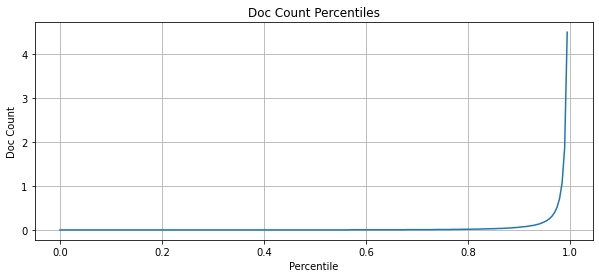

In [243]:
percentiles = np.arange(0.0, 1.0, 0.005)
percentile_values = word_info.DocPercent.quantile(percentiles)

plt.figure(figsize=(10, 4))
plt.title("Doc Count Percentiles")
plt.xlabel("Percentile")
plt.ylabel("Doc Count")
plt.plot(percentiles, percentile_values)
plt.grid(1)
plt.show()

In [271]:
word_info[word_info.Word.isin({'jazz', 'electronic', 'hop', 'hip', 'metal', 'experimental', 'nirvana', 'metallica', 'chains'})]

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
289,metal,28288,5411,0.058957,16.367211,1.809705
513,jazz,13540,3295,0.028220,9.966727,2.305614
582,hop,11584,3955,0.024143,11.963097,2.123091
583,hip,11565,3963,0.024104,11.987296,2.121070
835,electronic,7327,2917,0.015271,8.823351,2.427426
1757,experimental,2782,1723,0.005798,5.211736,2.953677
1929,metallica,2484,481,0.005177,1.454930,4.228135
2804,nirvana,1536,471,0.003201,1.424682,4.249100
2828,chains,1521,427,0.003170,1.291591,4.346956


In [272]:
key_words = word_info[
    (word_info.DocPercent <= 25) &
    (word_info.DocPercent >= 2)
].sort_values(by='DocPercent', ascending=False).reset_index(drop=True)

In [273]:
key_words

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,both,15184,8256,0.031646,24.972777,1.387263
1,black,29960,8244,0.062442,24.936479,1.388717
2,industry,24632,8236,0.051338,24.912281,1.389688
3,very,15358,8235,0.032009,24.909256,1.389809
4,again,17844,8219,0.037190,24.860859,1.391754
...,...,...,...,...,...,...
3043,comparison,741,662,0.001544,2.002420,3.909304
3044,sammy,1882,662,0.003922,2.002420,3.909304
3045,congas,843,662,0.001757,2.002420,3.909304
3046,husband,1029,662,0.002145,2.002420,3.909304


In [274]:
def get_tf(words):
    wc = {}
    for w in words:
        wc[w] = wc.get(w, 0) + 1
    return { w: c / len(words) for w, c in wc.items() }

def get_tf_idf(words, key_words):
    tf = get_tf(words)
    return scipy.sparse.csr.csr_matrix((key_words.Word.apply(tf.get) * key_words.IDF).fillna(0.0))

In [275]:
tfidfs = []
for _, album in albums.iterrows():
    a_words = ad_word_retriever.get_words(album.name, album.AlbumLink)
    a_tfidf = get_tf_idf(a_words, key_words)
    tfidfs.append(a_tfidf)
    if (len(tfidfs) % 1000) == 0:
        print(f"[{dt.datetime.now()}] Computed tf/idf of {len(tfidfs)} docs.")

[2021-10-26 08:37:57.735967] Computed tf/idf of 1000 docs.
[2021-10-26 08:38:03.017213] Computed tf/idf of 2000 docs.
[2021-10-26 08:38:08.413813] Computed tf/idf of 3000 docs.
[2021-10-26 08:38:13.427913] Computed tf/idf of 4000 docs.
[2021-10-26 08:38:18.994533] Computed tf/idf of 5000 docs.
[2021-10-26 08:38:24.770197] Computed tf/idf of 6000 docs.
[2021-10-26 08:38:30.910403] Computed tf/idf of 7000 docs.
[2021-10-26 08:38:36.766815] Computed tf/idf of 8000 docs.
[2021-10-26 08:38:42.451303] Computed tf/idf of 9000 docs.
[2021-10-26 08:38:48.352894] Computed tf/idf of 10000 docs.
[2021-10-26 08:38:53.900003] Computed tf/idf of 11000 docs.
[2021-10-26 08:38:59.030492] Computed tf/idf of 12000 docs.
[2021-10-26 08:39:04.000485] Computed tf/idf of 13000 docs.
[2021-10-26 08:39:09.163828] Computed tf/idf of 14000 docs.
[2021-10-26 08:39:14.030181] Computed tf/idf of 15000 docs.
[2021-10-26 08:39:19.217798] Computed tf/idf of 16000 docs.
[2021-10-26 08:39:24.298335] Computed tf/idf of 1

In [276]:
albums_emb = scipy.sparse.vstack(tfidfs)

In [277]:
albums_emb

<33059x3048 sparse matrix of type '<class 'numpy.float64'>'
	with 6390411 stored elements in Compressed Sparse Row format>

## Cluster Albums

In [278]:
km = MiniBatchKMeans(n_clusters=1000)

In [279]:
albums_clusters = km.fit_predict(albums_emb)

In [280]:
albums['Cluster'] = albums_clusters

In [281]:
cluster_counts = albums.groupby('Cluster').size().reset_index().rename(columns={0: 'Count'})

In [282]:
cluster_counts.sort_values(by='Count', ascending=False)

,Cluster,Count
1,1,6852
6,6,3466
149,161,1543
760,805,1427
39,43,1310
...,...,...
544,578,1
543,577,1
537,571,1
532,566,1


In [295]:
def show_other_albums(a_search):
    _albums = albums[albums.Album.fillna('').str.contains(a_search)]
    display(_albums)
    
    if len(_albums) > 0:
        display(albums[albums.Cluster.isin(_albums.Cluster.values)])

In [296]:
show_other_albums('(?i)Ride the light')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
25977,Metallica,Ride the Lightning,None,None,1984,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1984_albums,https://en.wikipedia.org/wiki/Ride_the_Lightning,351


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
407,Alien Weaponry,Tangaroa,"Groove metal, thrash metal, alternative metal",Napalm,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Tangaroa_(album),351
894,Labyrinth,Welcome to the Absurd Circus,"Power metal, progressive metal",Frontiers,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Welcome_to_the_A...,351
1022,Korpiklaani,Jylhä,Folk metal,Nuclear Blast,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Jylh%C3%A4,351
1280,The Crown,Royal Destroyer,,Metal Blade,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Royal_Destroyer,351
1391,Genghis Tron,Dream Weapon,,Relapse,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Dream_Weapon,351
...,...,...,...,...,...,...,...,...,...
27871,Judas Priest,Stained Class,None,None,1978,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1978_albums,https://en.wikipedia.org/wiki/Stained_Class,351
28090,Judas Priest,Killing Machine,None,None,1978,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1978_albums,https://en.wikipedia.org/wiki/Killing_Machine,351
28525,Judas Priest,Sad Wings of Destiny,None,None,1976,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1976_albums,https://en.wikipedia.org/wiki/Sad_Wings_of_Des...,351


In [297]:
show_other_albums('(?i)Spirit World Field')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
2961,Aesop Rock,Spirit World Field Guide,,Rhymesayers,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Spirit_World_Fie...,63


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
2961,Aesop Rock,Spirit World Field Guide,,Rhymesayers,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Spirit_World_Fie...,63
3369,Khalid,Free Spirit,R&B,RCA,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Free_Spirit_(Kha...,63
3767,Ceremony,In the Spirit World Now,"Post-punk, new wave",Relapse,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/In_the_Spirit_Wo...,63
4948,Depeche Mode,Spirit,Electronic,Columbia,2017,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2017_albums,https://en.wikipedia.org/wiki/Spirit_(Depeche_...,63
5738,Massive Attack,Ritual Spirit,"Trip hop, electronica",Virgin,2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Ritual_Spirit,63
5821,Lemon Demon,Spirit Phone,Pop,Needlejuice Records,2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Spirit_Phone,63
6562,Lee Kernaghan,Spirit of the Anzacs,Country,ABC Music,2015,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2015_albums,https://en.wikipedia.org/wiki/Spirit_of_the_An...,63
6930,Bring Me the Horizon,That's the Spirit,"Alternative rock, electronic rock, pop rock","Sony Music, Columbia, RCA",2015,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2015_albums,https://en.wikipedia.org/wiki/That%27s_the_Spirit,63
8950,Nelly Furtado,The Spirit Indestructible,"Pop, R&B","Interscope, Mosley, Mushroom",2012,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2012_albums,https://en.wikipedia.org/wiki/The_Spirit_Indes...,63


In [298]:
show_other_albums('(?i)Hot Rats')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
31039,Frank Zappa,Hot Rats,None,None,1969,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1969_albums,https://en.wikipedia.org/wiki/Hot_Rats,154


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
4651,Trisha Yearwood,Let's Be Frank,Country,Gwendolyn Records,2018,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2018_albums,https://en.wikipedia.org/wiki/Let%27s_Be_Frank,154
14550,Frank Zappa,Joe's Corsage,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Joe%27s_Corsage,154
14858,Frank Zappa,Quaudiophiliac,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Quaudiophiliac,154
14937,Frank Zappa,Joe's Domage,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Joe%27s_Domage,154
15245,Frank Zappa,Halloween,None,None,2003,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2003_albums,https://en.wikipedia.org/wiki/Halloween_(Frank...,154
...,...,...,...,...,...,...,...,...,...
31039,Frank Zappa,Hot Rats,None,None,1969,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1969_albums,https://en.wikipedia.org/wiki/Hot_Rats,154
31134,The Mothers of Invention,We're Only in It for the Money,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/We%27re_Only_in_...,154
31296,The Mothers of Invention,Cruising with Ruben & the Jets,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/Cruising_with_Ru...,154


## View Sample Details

In [10]:
sample_albums = albums_w_detail_links.sample(5).copy()

sample_albums['AlbumDetailHTML'] = sample_albums.AlbumLink.apply(lambda l: url_cache.get(l)['content'])

In [11]:
display(HTML(sample_albums.iloc[4].AlbumDetailHTML))